# Reads in a bigfile, grids its SPH particles and makes images and can calculate power spectrum

## First read everything in

In [1]:
import numpy as np
import bigfile
from fake_spectra import spectra
bf = bigfile.BigFile('PART_001')


# Read the header
header = bf['Header']

## Print all the attributes in the header
#for attr in header.attrs:
#    print(f"{attr}: {header.attrs[attr]}")

##print all the fields in the bigfile
#for key in bf.keys():
#    print(key)

#These are the parameters we need to know
BoxSize = float(header.attrs['BoxSize'])
Na = int(np.round(header.attrs['TotNumPartInit'][0]**(1/3)))
scale_factor = header.attrs['Time']
redshift = 1/scale_factor - 1
hubbleParam = header.attrs['HubbleParam']

print(f"BoxSize = {BoxSize}, Na = {Na}, redshift = {redshift}, hubbleParam = {hubbleParam}")


#these are the fields I need that describe particle positions
pos = bf['0/Position'][:]
Hsml = bf['0/SmoothingLength'][:]

#these are the fields I'm currently griding (although I don't think density is actually used)
dens = bf['0/Density'][:]
mass = bf['0/Mass'][:]
temp = bf['0/InternalEnergy'][:]  #this is currentluy internal energy and not temperature (will need to convert)

pos = pos.astype(np.float32)  #this array seems to be stored in float64, so am converting it to float32


print(np.shape(pos), np.shape(temp), np.shape(dens), mass.dtype, temp.dtype, pos.dtype, Hsml.dtype, dens.dtype)

BoxSize = 200.0, Na = 64, redshift = [499.], hubbleParam = [0.697]
(262144, 3) (262144,) (262144,) float32 float32 float32 float32 float32


/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_24083/324589655.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BoxSize = float(header.attrs['BoxSize'])


## Below uses the wrapped C code to grid the SPH particles

In [2]:

import wrapper
import numpy as np



# Define a numpy dtype for the gridStruct struct (shows what values are allowed))
#grid_dtype = np.dtype([('Rho', np.float32), ('T', np.float32), ('vel', np.float32, (3,))])
#print(type(pos), type(Hsml), type(temp), type(dens), type(mass),  Na, BoxSize)
grid_array =  wrapper.wrap_gridSPH(pos, Hsml, temp, dens,mass,  Na, BoxSize)

grid_array['Rho'] #just to see if it's doing something

print(Hsml)
Vcell = (BoxSize/Na)**3
#print(np.sum(grid_array['Rho'] )*Vcell, np.sum(DMgrid_array['Rho']), np.sum(mass), np.sum(massDM))

print(np.sum(grid_array['Rho'] )*Vcell, np.sum(mass), np.sum(grid_array['Rho'] )*Vcell/np.sum(mass)/1e10)

Name: QuinticSpline
Support: 3.000000
[9.505005 9.390934 9.434524 ... 9.347305 9.255612 9.294018]
0.010302624531277615 0.01030266 9.999965519408833e-11


In [3]:
grid_array['T'][1:10]

array([-1.5848819 , -1.3167324 ,  3.41729   , -1.4371012 , -2.3640785 ,
        1.3661094 , -1.1119096 , -0.49705744,  0.22742511], dtype=float32)

### Now let's create an image of a slice through the density

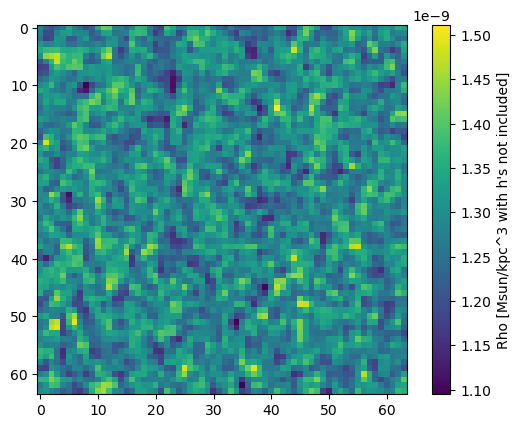

In [3]:
import matplotlib.pyplot as plt

# Choose a slice index
k = 0

# Reshape the array to 3D
rho_3d = grid_array['Rho'].reshape((Na, Na, Na))

# Take a slice at index k
rho_slice = rho_3d[:, :, k]

# Plot the slice
plt.imshow(rho_slice, cmap='viridis')
plt.colorbar(label='Rho [Msun/kpc^3 with h\'s not included]')
plt.show()

### and of temperature

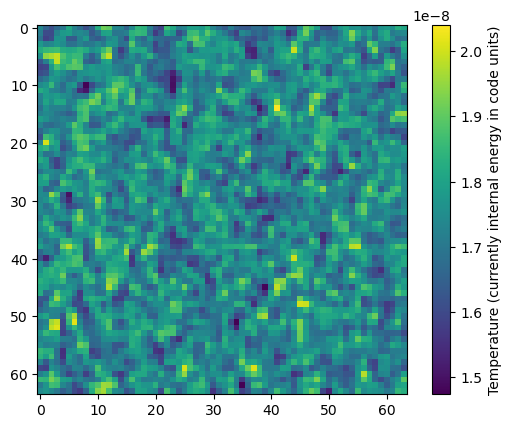

In [4]:
# Choose a slice index
k = 0

# Reshape the array to 3D
T_3d = grid_array['T'].reshape((Na, Na, Na))

# Take a slice at index k
T_slice = T_3d[:, :, k]

# Plot the slice
plt.imshow(T_slice, cmap='viridis')
plt.colorbar(label='Temperature (currently internal energy in code units)')
plt.show()

# Now let's calculate the power spectrum

shape: 64 is_3d: True
0.002076317537632959 0.0020750393 8.8599336e-08 3.100627668029983e-05


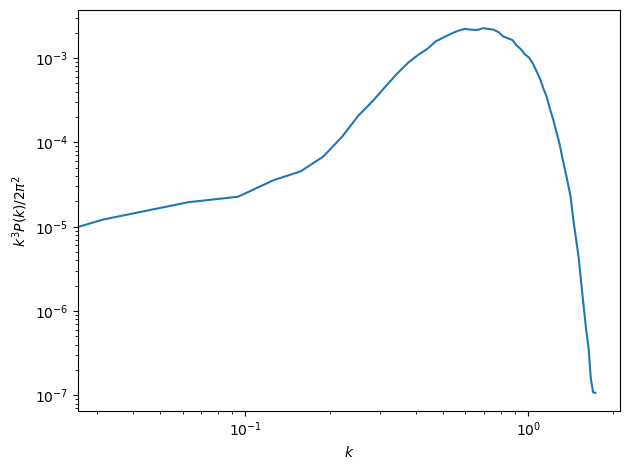

In [5]:
import importlib
import power_spectrum as power

importlib.reload(power)

rho_3d = grid_array['Rho'].reshape((Na, Na, Na))
#rho_3d = np.random.normal(loc=0.0, scale=1.0, size=(Na, Na, Na)) #white power for testing

if np.abs(np.average(rho_3d))> 1e-4*np.std(rho_3d):  #checking if already zero mean (by comparing relative to RMS)
    overdensity_3d = rho_3d/np.average(rho_3d) - 1
else:
    print("already zero mean, so not taking overdensity!!!!")
    overdensity_3d = rho_3d


overdensityfft = np.fft.rfftn(overdensity_3d)

dcubek = (2*np.pi/BoxSize)**3
power_normalization = (BoxSize**3/Na**3)**2/BoxSize**3  #need to normalize appropriately for cosmology which has particular Fourier convention

overdensity_power, nummodes = power.average_fft_power_spectrum(overdensityfft[np.newaxis, ...], Na, True)  #need another axis because can input a list of arrays

overdensity_power = power_normalization*overdensity_power  #normalize to correct fourier convention in cosmology
karray = 2*np.pi/BoxSize*np.arange(0, len(overdensity_power))  #this is the k array for the power spectrum

print(np.average(np.abs(overdensityfft)**2)/Na**3, np.average(overdensity_3d**2), np.mean(overdensity_3d), dcubek)
# Plot the power spectrum
plt.xlabel('$k$')
#plt.ylabel('$P(k)$')
#plt.loglog(karray,overdensity_power)

plt.ylabel(r'$k^3P(k)/2\pi^2$')
plt.loglog(karray, karray**3*overdensity_power/(2*np.pi**2)) #k^3P(k)/(2pi^2) vs k (the area under curve is variance)

#My attempt to understand number of modes in box
#plt.loglog(karray,  2*nummodes)
#plt.loglog(karray,  karray**2/(2*np.pi**2)*2*np.pi/BoxSize*BoxSize**3)

# Display the plots
plt.tight_layout()
plt.show()

### This is just a check that I'm normalizing correctly

In [6]:
import numpy as np

dk = 2*np.pi/BoxSize
# Assuming karray and overdensity_power are numpy arrays of the same size
integral = np.trapz(karray**2 * overdensity_power, x=karray)/(2*np.pi**2)  #this overshoots because there aren't as many modes in the box for the white power
integral2 = np.trapz(2*nummodes * overdensity_power, x=karray)/(BoxSize**3)/dk #this accounts for number of modes (the fft only counts modes in half of space, so we have to multiply by two)

print(integral, integral2)


0.0020902450926162104 0.002141202460368712


## Let's now do the same for the dark matter

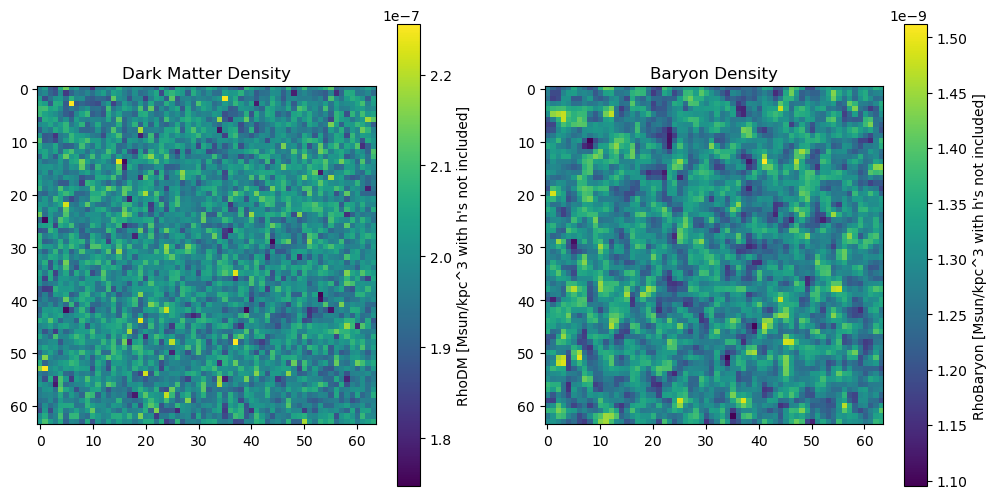

In [7]:
#need to use the DM arrays  (if you put in gas here, it will CIC gas...which is a good test)
posDM = bf['1/Position'][:]
massDM = bf['1/Mass'][:]
posDM = posDM.astype(np.float32) 


DMgrid_array =  wrapper.wrap_gridDM(posDM, massDM,  Na, BoxSize)


#Now let's plot
import matplotlib.pyplot as plt

# Choose a slice index
k = 0

# Reshape the arrays to 3D
rhoDM_3d = DMgrid_array['Rho'].reshape((Na, Na, Na))
rhoBaryon_3d = grid_array['Rho'].reshape((Na, Na, Na))

# Take a slice at index k
rhoDM_slice = rhoDM_3d[:, :, k]
rhoBaryon_slice = rhoBaryon_3d[:, :, k]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the DM density slice
im1 = axs[0].imshow(rhoDM_slice, cmap='viridis')
fig.colorbar(im1, ax=axs[0], label='RhoDM [Msun/kpc^3 with h\'s not included]')
axs[0].set_title('Dark Matter Density')

# Plot the baryon density slice
im2 = axs[1].imshow(rhoBaryon_slice, cmap='viridis')
fig.colorbar(im2, ax=axs[1], label='RhoBaryon [Msun/kpc^3 with h\'s not included]')
axs[1].set_title('Baryon Density')

plt.show()

shape: 64 is_3d: True
shape: 64 is_3d: True


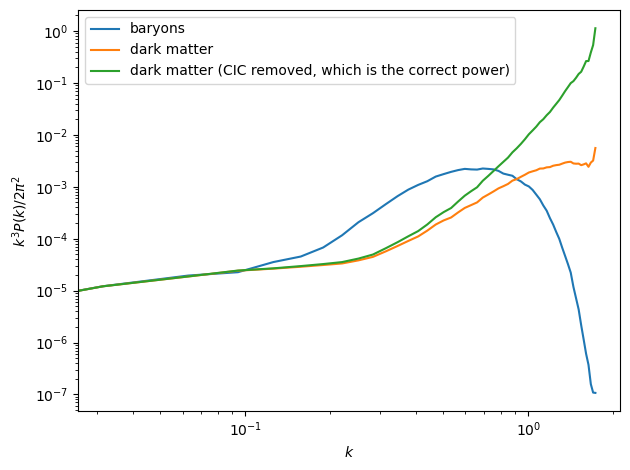

In [8]:
import importlib
import power_spectrum as power

importlib.reload(power)

DMrho_3d = DMgrid_array['Rho'].reshape((Na, Na, Na))
#rho_3d = np.random.normal(loc=0.0, scale=1.0, size=(Na, Na, Na)) #white power for testing

if np.abs(np.average(DMrho_3d))> 1e-4*np.std(DMrho_3d):  #checking if already zero mean (by comparing relative to RMS)
    DMoverdensity_3d = DMrho_3d/np.average(DMrho_3d) - 1
else:
    print("already zero mean, so not taking overdensity!!!!")
    DMoverdensity_3d = rho_3d



DMoverdensityfft = np.fft.rfftn(DMoverdensity_3d)


DMoverdensityfft_noCICWindow = power.removeCICWindow(DMoverdensityfft, BoxSize, Na)

DMoverdensity_power, nummodes = power.average_fft_power_spectrum(DMoverdensityfft[np.newaxis, ...], Na, True)  #need another axis because can input a list of arrays

DMoverdensity_power_noCICWindow , nummodes = power.average_fft_power_spectrum(DMoverdensityfft_noCICWindow [np.newaxis, ...], Na, True)  #need another axis because can input a list of arrays

DMoverdensity_power = power_normalization*DMoverdensity_power #renormalize to correct fourier convention in cosmology
DMoverdensity_power_noCICWindow = power_normalization*DMoverdensity_power_noCICWindow #renormalize to correct fourier convention in cosmology

karray = 2*np.pi/BoxSize*np.arange(0, len(overdensity_power))  #this is the k array for the power spectrum

plt.xlabel(r'$k$')
plt.ylabel(r'$k^3P(k)/2\pi^2$')
plt.loglog(karray, karray**3*overdensity_power/(2*np.pi**2), label='baryons') #k^3P(k)/(2pi^2) vs k (the area under curve is variance)
plt.loglog(karray, karray**3*DMoverdensity_power/(2*np.pi**2), label='dark matter')
plt.loglog(karray, karray**3*DMoverdensity_power_noCICWindow/(2*np.pi**2), label='dark matter (CIC removed, which is the correct power)')

#My attempt to understand number of modes in box
#plt.loglog(karray,  2*nummodes)
#plt.loglog(karray,  karray**2/(2*np.pi**2)*2*np.pi/BoxSize*BoxSize**3)

# Display the plots
plt.legend()
plt.tight_layout()
plt.show()